# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from scipy import stats
from sklearn.preprocessing import RobustScaler
from functions.khi_2 import cramers_v

# Link / objectives

Energy star : https://www.energystar.gov/buildings/benchmark/analyze_benchmarking_results

Problématique de la ville de Seattle
Des relevés minutieux ont été effectués par vos agents en __2015 et en 2016__. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction..)

Vous cherchez également à évaluer l’intérêt de __l’"ENERGY STAR Score"__ pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe.

Votre mission:

- __Réaliser une courte analyse exploratoire.__
- __Tester différents modèles de prédiction afin de répondre au mieux à la problématique.__\


Avant de quitter la salle de brief, Douglas, le project lead, vous donne quelques pistes, et erreurs à éviter :

- L’objectif est de te passer des relevés de consommation annuels (attention à la fuite de données), mais rien ne t'interdit d’en déduire des variables plus simples (nature et proportions des sources d’énergie utilisées). 

- Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

- Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithme de ML à l’aide d’une validation croisée.

# Load and clean

## Load Data

In [2]:
df_2015=pd.read_csv('./data/2015-building-energy-benchmarking.csv')
df_2016=pd.read_csv('./data/2016-building-energy-benchmarking.csv')

Le fait d'avoir deux datasets est embetant -> je vais essayer de les concatener sans perdre de la data

## Columns analysis

Analyse des colonnes pour pouvoir concat les deux datasets

In [3]:
len(df_2015.columns)==len(df_2016.columns)

False

In [4]:
col_2015=[]
for column in list(df_2015.columns):
    if column not in (df_2016.columns):
        col_2015.append(column)
print(f"colonnes de 2015 non présente dans 2016 : ")
[print(f'- {i}') for i in col_2015]

colonnes de 2015 non présente dans 2016 : 
- Location
- OtherFuelUse(kBtu)
- GHGEmissions(MetricTonsCO2e)
- GHGEmissionsIntensity(kgCO2e/ft2)
- Comment
- 2010 Census Tracts
- Seattle Police Department Micro Community Policing Plan Areas
- City Council Districts
- SPD Beats
- Zip Codes


[None, None, None, None, None, None, None, None, None, None]

In [5]:
col_2016=[]
for column in list(df_2016.columns):
    if column not in (df_2015.columns):
        col_2016.append(column)
print(f"colonnes de 2015 non présente dans 2016 : ")
[print(f'- {i}') for i in col_2016]

colonnes de 2015 non présente dans 2016 : 
- Address
- City
- State
- ZipCode
- Latitude
- Longitude
- Comments
- TotalGHGEmissions
- GHGEmissionsIntensity


[None, None, None, None, None, None, None, None, None]

<AxesSubplot:xlabel='variable', ylabel='value'>

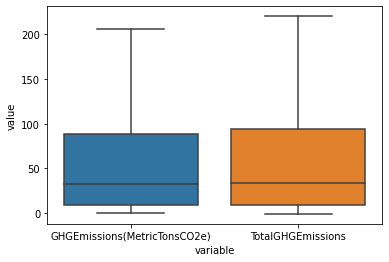

In [6]:
concat_data_1 =pd.concat([df_2015['GHGEmissions(MetricTonsCO2e)'], df_2016['TotalGHGEmissions']], axis=1)
sns.boxplot(x="variable", y="value", data=pd.melt(concat_data_1), showfliers=False)

In [7]:
#seems the same

<AxesSubplot:xlabel='variable', ylabel='value'>

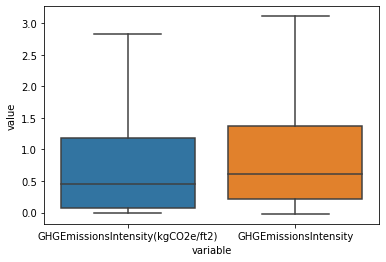

In [8]:
concat_data_2 =pd.concat([df_2015['GHGEmissionsIntensity(kgCO2e/ft2)'], df_2016['GHGEmissionsIntensity']], axis=1)
sns.boxplot(x="variable", y="value", data=pd.melt(concat_data_2), showfliers=False)

In [9]:
#seems the same

In [10]:
df_2015['OtherFuelUse(kBtu)'].value_counts()

0.0          3313
6464408.0       1
178094.0        1
143134.0        1
5596.0          1
229942.0        1
145944.0        1
427938.0        1
1943011.0       1
12551.0         1
547.0           1
15527.0         1
2304567.0       1
2944419.0       1
337952.0        1
8269669.0       1
177849.0        1
182715.0        1
Name: OtherFuelUse(kBtu), dtype: int64

__Todo :__\
__2015__ 
 - Location : extract data [latitude and longitude, adress, ...]
 - comment/comments ->rename
 - GHGEmissions(MetricTonsCO2e) <->TotalGHGEmissions au vue de la data -> rename
 - 'GHGEmissionsIntensity(kgCO2e/ft2)' <-> 'GHGEmissionsIntensity' -> rename
 - OtherFuelUse(kBtu) : peu d'info -> drop
 - Seattle Police Department Micro Community Policing Plan Areas -> semble non relié à notre probleme -> drop
 - City Council Districts : idem -> drop
 - SPD Beats : semble être des problématique police -> drop
 - Zip Codes : je sais ap ce que c'est -> drop


## Data engeeniring for concat

### deal with Location column

In [11]:
# eval - > permet d'eviter d'avoir un format pourri
df_2015['Location'] = [eval(str(item)) for index, item in df_2015.Location.iteritems()]

In [12]:
df_2015['Latitude'] = df_2015['Location'].apply(lambda x : x['latitude'])
df_2015['Longitude'] = df_2015['Location'].apply(lambda x : x['longitude'])
df_2015['City'] = df_2015['Location'].apply(lambda x : eval(x['human_address'])['city'])
df_2015['State'] = df_2015['Location'].apply(lambda x : eval(x['human_address'])['state'])
df_2015['ZipCode'] = df_2015['Location'].apply(lambda x : eval(x['human_address'])['zip'])

### Deal with renaming + drop

In [13]:
df_2015.rename(columns={'GHGEmissions(MetricTonsCO2e)' : 'TotalGHGEmissions',
                       'GHGEmissionsIntensity(kgCO2e/ft2)' : 'GHGEmissionsIntensity',
                       'Comment':'Comments'},
              inplace=True)

In [14]:
df_2015.drop(columns=['OtherFuelUse(kBtu)',
                      'Seattle Police Department Micro Community Policing Plan Areas', 
                      'City Council Districts',
                      'SPD Beats',
                      'Zip Codes',
                      'Location'],
            inplace=True)

### Concat Df 🍾

In [15]:
list(df_2015.columns).sort() == list(df_2016.columns).sort()

True

In [16]:
df = pd.concat([df_2015, df_2016], axis=0)

In [17]:
df.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'DefaultData', 'Comments',
       'ComplianceStatus', 'Outlier', '2010 Census Tracts', 

# Data Explo

__Definitions :__
- __GFA__ = Gross Floor Area : is the total property square footage, as measured between the exterior walls of the building(s)

In [18]:
# REMOVE residential building !
df=df[~df.BuildingType.isin(['Multifamily MR (5-9)', 'Multifamily LR (1-4)', 'Multifamily HR (10+)'])]
df.BuildingType.unique()

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus', 'Nonresidential WA'], dtype=object)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3318 entries, 0 to 3375
Data columns (total 47 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3318 non-null   int64  
 1   DataYear                         3318 non-null   int64  
 2   BuildingType                     3318 non-null   object 
 3   PrimaryPropertyType              3318 non-null   object 
 4   PropertyName                     3318 non-null   object 
 5   TaxParcelIdentificationNumber    3317 non-null   object 
 6   CouncilDistrictCode              3318 non-null   int64  
 7   Neighborhood                     3318 non-null   object 
 8   YearBuilt                        3318 non-null   int64  
 9   NumberofBuildings                3316 non-null   float64
 10  NumberofFloors                   3310 non-null   float64
 11  PropertyGFATotal                 3318 non-null   int64  
 12  PropertyGFAParking  

In [20]:
cat_columns=[]
numeric_columns=[]
for column in list(df.columns):
    if df[column].dtype=='object' :
        cat_columns.append(column)
    else :
        numeric_columns.append(column)

In [21]:
df.select_dtypes('float').columns

Index(['NumberofBuildings', 'NumberofFloors', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', '2010 Census Tracts'],
      dtype='object')

## Numeric columns

### premiere analyse

In [22]:
df[numeric_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3318 entries, 0 to 3375
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3318 non-null   int64  
 1   DataYear                         3318 non-null   int64  
 2   CouncilDistrictCode              3318 non-null   int64  
 3   YearBuilt                        3318 non-null   int64  
 4   NumberofBuildings                3316 non-null   float64
 5   NumberofFloors                   3310 non-null   float64
 6   PropertyGFATotal                 3318 non-null   int64  
 7   PropertyGFAParking               3318 non-null   int64  
 8   PropertyGFABuilding(s)           3318 non-null   int64  
 9   LargestPropertyUseTypeGFA        3247 non-null   float64
 10  SecondLargestPropertyUseTypeGFA  1667 non-null   float64
 11  ThirdLargestPropertyUseTypeGFA   684 non-null    float64
 12  ENERGYSTARScore     

OSEBuildingID


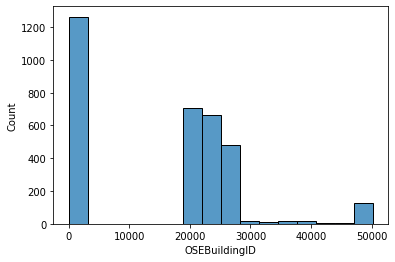

DataYear
2016    1668
2015    1650
Name: DataYear, dtype: int64


CouncilDistrictCode
7    1062
2     791
3     404
4     332
5     264
1     236
6     229
Name: CouncilDistrictCode, dtype: int64


YearBuilt


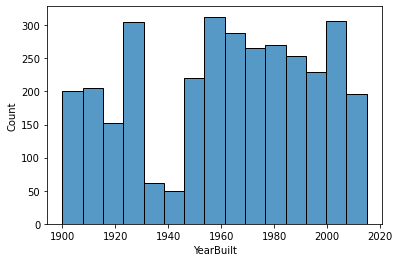

NumberofBuildings


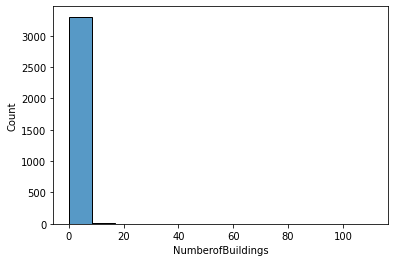

NumberofFloors


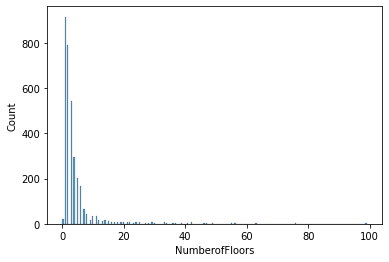

PropertyGFATotal


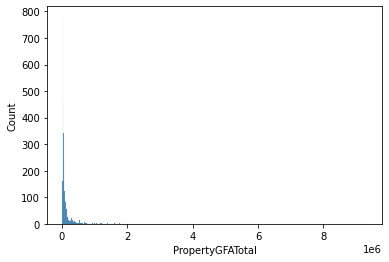

PropertyGFAParking


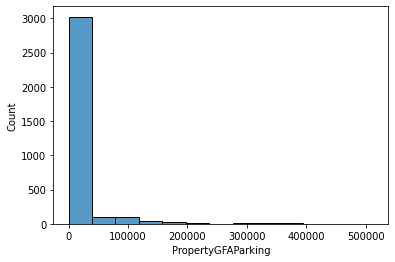

PropertyGFABuilding(s)


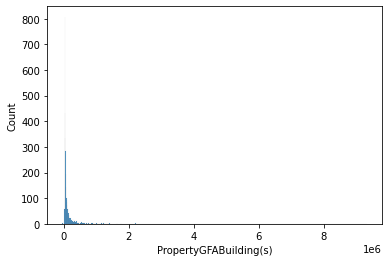

LargestPropertyUseTypeGFA


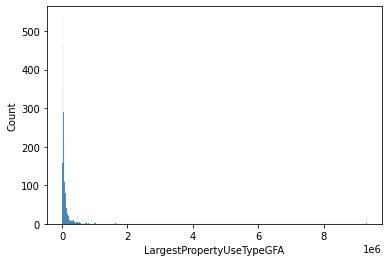

SecondLargestPropertyUseTypeGFA


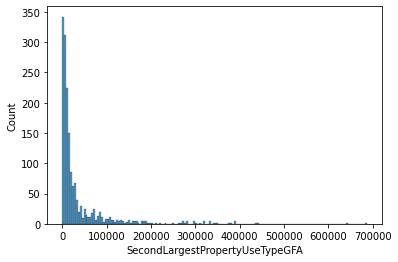

ThirdLargestPropertyUseTypeGFA


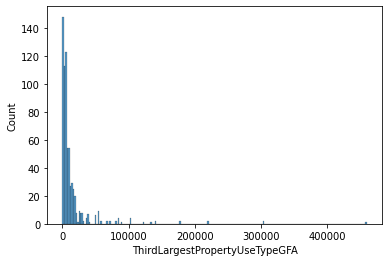

ENERGYSTARScore


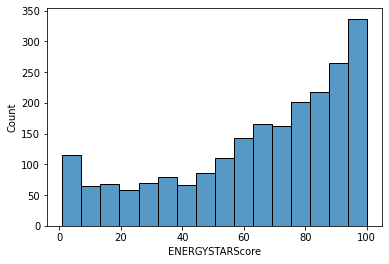

SiteEUI(kBtu/sf)


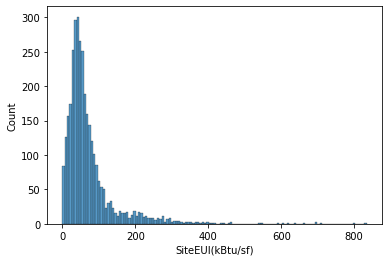

SiteEUIWN(kBtu/sf)


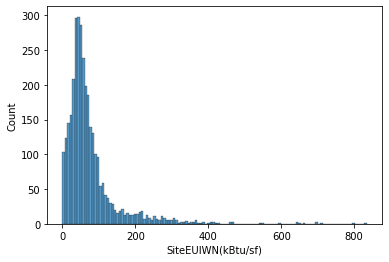

SourceEUI(kBtu/sf)


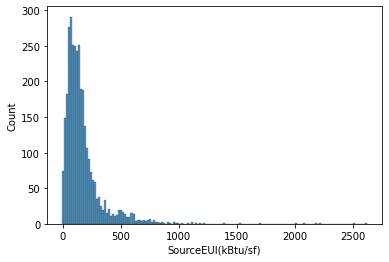

SourceEUIWN(kBtu/sf)


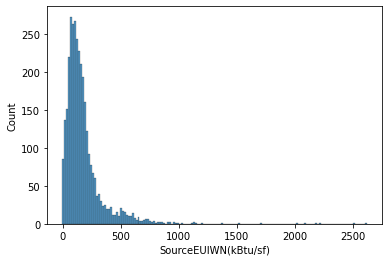

SiteEnergyUse(kBtu)


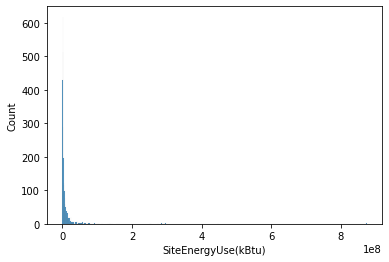

SiteEnergyUseWN(kBtu)


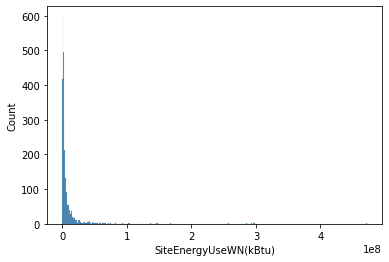

SteamUse(kBtu)


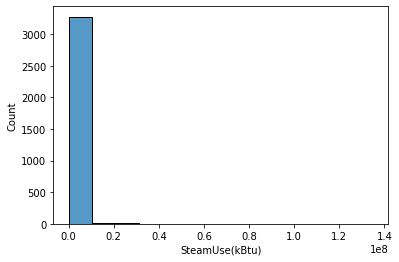

Electricity(kWh)


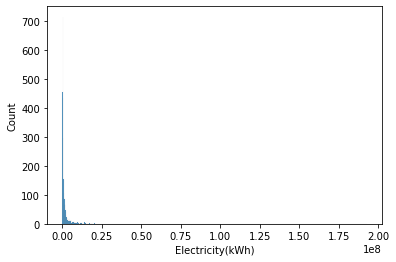

Electricity(kBtu)


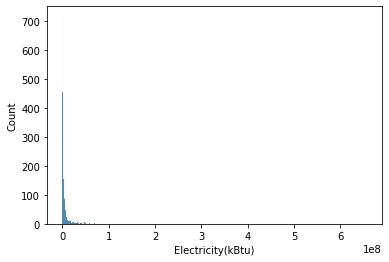

NaturalGas(therms)


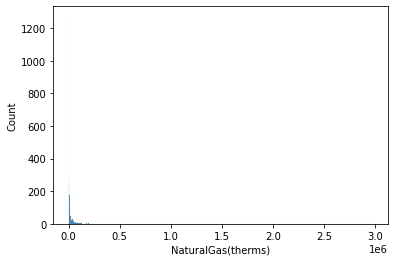

NaturalGas(kBtu)


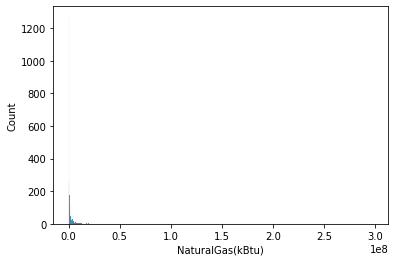

TotalGHGEmissions


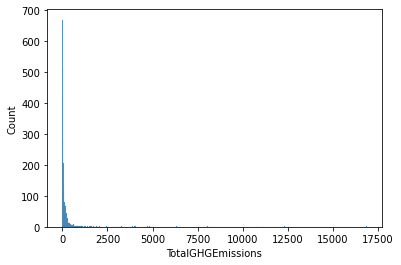

GHGEmissionsIntensity


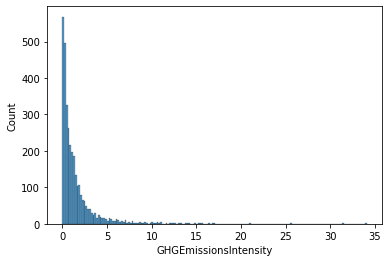

2010 Census Tracts


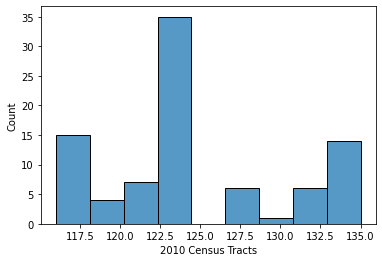

In [23]:
for column in numeric_columns:
    if len(df[column].value_counts())<10:
        print(column)
        print(df[column].value_counts())
        print('\n')
    else :
        print(column)
        sns.histplot(df[column])
        plt.show()

In [24]:
numeric_columns

['OSEBuildingID',
 'DataYear',
 'CouncilDistrictCode',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA',
 'ENERGYSTARScore',
 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SiteEnergyUseWN(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kWh)',
 'Electricity(kBtu)',
 'NaturalGas(therms)',
 'NaturalGas(kBtu)',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 '2010 Census Tracts']

<AxesSubplot:>

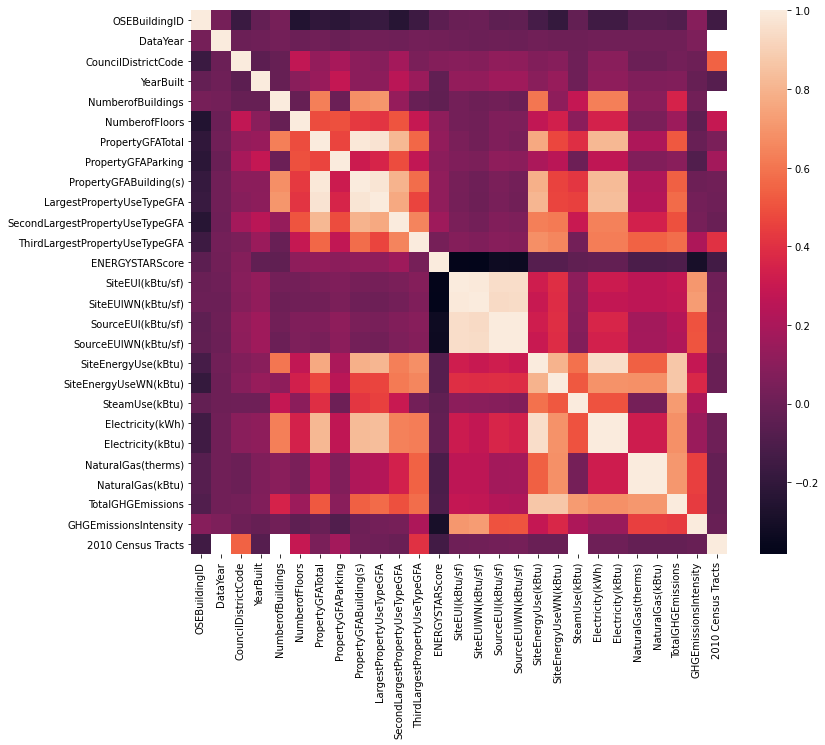

In [25]:
plt.figure(figsize=(12,10))
sns.heatmap(df[numeric_columns].corr())

In [26]:
corr = df.corr()
corr.style.background_gradient(cmap='Greens').set_precision(3)

/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_2158/2921387194.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='Greens').set_precision(3)


,OSEBuildingID,DataYear,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,2010 Census Tracts
OSEBuildingID,1.000,0.029,-0.167,-0.025,0.036,-0.256,-0.209,-0.222,-0.183,-0.172,-0.240,-0.158,-0.053,-0.008,0.001,-0.046,-0.042,-0.127,-0.189,-0.029,-0.150,-0.150,-0.070,-0.070,-0.089,0.083,-0.148
DataYear,0.029,1.000,-0.004,0.012,0.023,-0.001,0.013,-0.009,0.015,0.015,0.010,0.027,0.022,0.008,-0.004,0.002,-0.003,0.015,0.004,0.004,0.012,0.012,0.012,0.012,0.012,0.058,nan
CouncilDistrictCode,-0.167,-0.004,1.000,-0.051,-0.020,0.274,0.129,0.195,0.102,0.087,0.181,0.047,0.079,0.090,0.081,0.116,0.112,0.068,0.083,0.011,0.096,0.096,0.001,0.001,0.025,0.004,0.544
YearBuilt,-0.025,0.012,-0.051,1.000,-0.019,0.095,0.142,0.282,0.100,0.108,0.251,0.151,-0.036,0.130,0.122,0.167,0.164,0.096,0.140,0.009,0.113,0.113,0.063,0.063,0.066,-0.016,-0.072
NumberofBuildings,0.036,0.023,-0.020,-0.019,1.000,-0.019,0.632,0.001,0.677,0.698,0.136,-0.012,-0.040,0.023,0.004,0.021,0.001,0.603,0.112,0.285,0.632,0.632,0.097,0.097,0.349,0.022,nan
NumberofFloors,-0.256,-0.001,0.274,0.095,-0.019,1.000,0.486,0.497,0.429,0.417,0.507,0.292,0.112,0.028,0.014,0.066,0.057,0.271,0.331,0.102,0.344,0.344,0.045,0.045,0.153,-0.046,0.289
PropertyGFATotal,-0.209,0.013,0.129,0.142,0.632,0.486,1.000,0.465,0.986,0.972,0.811,0.559,0.124,0.045,0.017,0.065,0.041,0.767,0.470,0.392,0.815,0.815,0.211,0.211,0.519,-0.011,0.049
PropertyGFAParking,-0.222,-0.009,0.195,0.282,0.001,0.497,0.465,1.000,0.312,0.354,0.485,0.273,0.099,0.065,0.054,0.110,0.103,0.205,0.250,0.004,0.266,0.266,0.068,0.068,0.094,-0.086,0.179
PropertyGFABuilding(s),-0.183,0.015,0.102,0.100,0.677,0.429,0.986,0.312,1.000,0.976,0.797,0.575,0.117,0.036,0.009,0.049,0.025,0.785,0.457,0.420,0.825,0.825,0.214,0.214,0.539,0.005,0.017
LargestPropertyUseTypeGFA,-0.172,0.015,0.087,0.108,0.698,0.417,0.972,0.354,0.976,1.000,0.767,0.464,0.116,0.032,0.006,0.042,0.018,0.807,0.465,0.453,0.836,0.836,0.233,0.233,0.572,0.026,0.009


colonne contenant WN:
- "Weather Normalized (WN) Site Energy Use Intensity (EUI) is a property's WN Site Energy divided by its gross floor area (in square feet). WN Site Energy is the Site Energy Use the property would have consumed during 30-year average weather conditions. WN Site EUI is measured in measured in thousands of British thermal units (kBtu) per square foot." -> semble peut pertinant à premiere vue 


In [27]:
numeric_to_drop=[
    'SiteEnergyUseWN(kBtu)',
    'SiteEUIWN(kBtu/sf)',
    'SourceEUIWN(kBtu/sf)',
    'Electricity(kWh)', #je garde en kwh
    'NaturalGas(therms)',
    '2010 Census Tracts',#trop d'outliers
    'LargestPropertyUseTypeGFA',# a voir
    'SecondLargestPropertyUseTypeGFA',#a voir
    'ThirdLargestPropertyUseTypeGFA',#a voir
    'SiteEUI(kBtu/sf)', # pour la problématique je suprime ces données dépendantes de la surface
    'SourceEUI(kBtu/sf)',# pour la problématique je suprime ces données dépendantes de la surface
    'GHGEmissionsIntensity',# pour la problématique je suprime ces données dépendantes de la surface
    'SteamUse(kBtu)', #à éviter car provient de relevé
    'Electricity(kBtu)', #à éviter car provient de relevé
    'NaturalGas(kBtu)', #à éviter car provient de relevé
    
    ]
#'PropertyGFATotal' #du à la corrélation avec PropertyGFPrking /Building(s)

In [28]:
df.drop(columns=numeric_to_drop, inplace=True)

In [29]:
numeric_columns = [i for i in numeric_columns if i not in numeric_to_drop]

### Check outliers

In [30]:
df[numeric_columns].describe()

,OSEBuildingID,DataYear,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions
count,3318.000000,3318.000000,3318.000000,3318.000000,3316.000000,3310.000000,3.318000e+03,3318.000000,3.318000e+03,2211.000000,3.309000e+03,3309.000000
mean,15951.816154,2015.502712,4.365883,1961.536769,1.117310,4.126888,1.156672e+05,13303.304702,1.023639e+05,64.815920,8.068625e+06,177.038779
std,13411.897096,0.500068,2.195304,32.709772,2.219845,6.567333,2.511222e+05,43596.620504,2.340749e+05,28.549886,2.525462e+07,666.442480
min,1.000000,2015.000000,1.000000,1900.000000,0.000000,0.000000,1.128500e+04,-2.000000,-5.055000e+04,1.000000,0.000000e+00,-0.800000
25%,579.000000,2015.000000,2.000000,1930.000000,1.000000,1.000000,2.951225e+04,0.000000,2.850775e+04,47.000000,1.223425e+06,19.720000
50%,21122.000000,2016.000000,4.000000,1965.000000,1.000000,2.000000,4.924600e+04,0.000000,4.736800e+04,72.000000,2.505271e+06,49.160000
75%,24556.750000,2016.000000,7.000000,1989.000000,1.000000,4.000000,1.047860e+05,0.000000,9.447150e+04,89.000000,6.917280e+06,138.870000
max,50226.000000,2016.000000,7.000000,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,100.000000,8.739237e+08,16870.980000


__Pour remplir les données manquantes des étages/nombres de batiments :__
- remplir par la vaeur associé à l'id du batiment de l'autre année
- par défaut : par 0
- puis remplacer 0 par 1.. *-> à voir implémentation méthode par la moyenne des batiements de la même catégorie ?*

In [31]:
#NumberofBuildings
df['NumberofBuildings'] = df['NumberofBuildings'].fillna(df.groupby('OSEBuildingID')['NumberofBuildings'].transform('max'))
df['NumberofBuildings']=df['NumberofBuildings'].fillna(0)
df['NumberofBuildings'] = df['NumberofBuildings'].replace(0.0, 1.0)
df['NumberofBuildings'].unique()

array([  1.,   7.,  11.,  16.,   4.,   3.,  39.,   2.,  10.,   6.,  27.,
        14.,   9.,   5.,   8.,  23., 111.])

In [32]:
#NumberofFloors cant be 0 floors + deal with outliers
df['NumberofFloors'] = df['NumberofFloors'].fillna(df.groupby('OSEBuildingID')['NumberofFloors'].transform('max'))
df['NumberofFloors'] = df['NumberofFloors'].replace(0.0, 1.0)

In [33]:
df['NumberofFloors'].value_counts()

1.0     943
2.0     789
3.0     541
4.0     295
5.0     202
6.0     167
7.0      67
8.0      43
11.0     36
10.0     35
14.0     17
12.0     16
9.0      16
15.0     13
13.0     13
19.0     10
42.0     10
17.0      8
29.0      6
21.0      6
22.0      6
16.0      6
20.0      6
24.0      6
33.0      6
25.0      6
18.0      6
23.0      5
34.0      4
36.0      4
41.0      4
46.0      2
99.0      2
76.0      2
27.0      2
56.0      2
30.0      2
63.0      2
55.0      2
37.0      2
49.0      2
28.0      2
47.0      2
39.0      2
Name: NumberofFloors, dtype: int64

In [34]:
#PropertyGFAParking
df['PropertyGFAParking']=df['PropertyGFAParking'].replace(-2.0, 0.0)
df['PropertyGFAParking'].min()

0

In [35]:
# PropertyGFABuilding(s)
property_gfa_building_neg = list(df[(df['PropertyGFABuilding(s)']<0)]['OSEBuildingID'])
for id_ in property_gfa_building_neg: 
    to_replace = df[(df['OSEBuildingID']==id_)&(df['PropertyGFABuilding(s)']<0)]['PropertyGFABuilding(s)'].item()
    value = df[(df['OSEBuildingID']==id_)&(df['PropertyGFABuilding(s)']>0)]['PropertyGFABuilding(s)'].item()
    df['PropertyGFABuilding(s)']=df['PropertyGFABuilding(s)'].replace(to_replace, value)

In [36]:
df['PropertyGFABuilding(s)'].min()

3636

In [37]:
#PropertyGFA total
property_gfa_building_neg = list(df[(df['PropertyGFATotal']<0)]['OSEBuildingID'])
for id_ in property_gfa_building_neg: 
    to_replace = df[(df['OSEBuildingID']==id_)&(df['PropertyGFATotal']<0)]['PropertyGFATotal'].item()
    value = df[(df['OSEBuildingID']==id_)&(df['PropertyGFATotal']>0)]['PropertyGFATotal'].item()
    df['PropertyGFATotal']=df['PropertyGFATotal'].replace(to_replace, value)

In [38]:
# calcul ratio parking/surface totale
df['parking_ratio']=df['PropertyGFAParking']/df['PropertyGFATotal']*100
df['building_ratio']=df['PropertyGFABuilding(s)']/df['PropertyGFATotal']*100

In [39]:
df[df.parking_ratio>80]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,...,ComplianceStatus,Outlier,Latitude,Longitude,City,State,ZipCode,Address,parking_ratio,building_ratio
3139,29788,2015,NonResidential,Small- and Mid-Sized Office,QUEEN ANNE SQUARE WEST (2013),7015350000,7,MAGNOLIA / QUEEN ANNE,1982,1.0,...,Compliant,NaN,47.62496806,-122.359705,SEATTLE,WA,98119,NaN,180.181431,100.000000
3322,50002,2015,NonResidential,Other,FREEWAY MOTORS UNIVERSITY AUDI,6746701515,4,NORTHEAST,2014,1.0,...,Compliant,NaN,47.66411096,-122.3166394,SEATTLE,WA,98105,NaN,250.231812,100.000000
1109,20885,2016,NonResidential,Senior Care Community,Ballard Center,1865400030,6,BALLARD,1966,1.0,...,Compliant,NaN,47.69875,-122.36725,Seattle,WA,98117.0,820 NW 95th Street,89.502252,10.497748


In [40]:
df[df.OSEBuildingID==20885][['DataYear','PropertyGFAParking', 'PropertyGFABuilding(s)', 'PropertyGFATotal', 'SiteEnergyUse(kBtu)']]

,DataYear,PropertyGFAParking,PropertyGFABuilding(s),PropertyGFATotal,SiteEnergyUse(kBtu)
1122,2015,0,60422,60422,10420096.0
1109,2016,31000,3636,34636,12148720.0


In [41]:
df.loc[3139, 'PropertyGFAParking']=0
df.loc[3322, 'PropertyGFAParking']=0
df.drop(1109, inplace=True)

In [42]:
df['parking_ratio']=df['PropertyGFAParking']/df['PropertyGFATotal']*100

In [43]:
df[['parking_ratio', 'building_ratio', 'PropertyGFATotal', 'PropertyGFABuilding(s)', 'PropertyGFAParking']].corr()

,parking_ratio,building_ratio,PropertyGFATotal,PropertyGFABuilding(s),PropertyGFAParking
parking_ratio,1.000000,-1.000000,0.178742,0.067170,0.669697
building_ratio,-1.000000,1.000000,-0.178742,-0.067170,-0.669697
PropertyGFATotal,0.178742,-0.178742,1.000000,0.986346,0.465445
PropertyGFABuilding(s),0.067170,-0.067170,0.986346,1.000000,0.313329
PropertyGFAParking,0.669697,-0.669697,0.465445,0.313329,1.000000


In [44]:
df.drop(columns=['PropertyGFATotal', 'PropertyGFAParking'], inplace=True)
numeric_columns=[i for i in numeric_columns if i not in numeric_to_drop if numeric_columns not in [
    'PropertyGFATotal', 'PropertyGFAParking']]
numeric_columns.append('parking_ratio')
numeric_columns.append('building_ratio')

## Cat Columns

In [45]:
for column in cat_columns:
    if len(df[column].value_counts())<10:
        print(column)
        print(df[column].value_counts())
        print(f"{len(df[df[column].isna()])} valeurs manquantes'")
        print('\n')
    else :
        print(f'la colonne {column} contient {len(df[column].value_counts())} valeurs différentes et {len(df[df[column].isna()])} valeurs manquantes')
        print('\n')
    

BuildingType
NonResidential        2919
SPS-District K-12      197
Nonresidential COS     153
Campus                  46
Nonresidential WA        1
Name: BuildingType, dtype: int64
0 valeurs manquantes'


la colonne PrimaryPropertyType contient 30 valeurs différentes et 0 valeurs manquantes


la colonne PropertyName contient 3202 valeurs différentes et 0 valeurs manquantes


la colonne TaxParcelIdentificationNumber contient 1835 valeurs différentes et 1 valeurs manquantes


la colonne Neighborhood contient 19 valeurs différentes et 0 valeurs manquantes


la colonne ListOfAllPropertyUseTypes contient 387 valeurs différentes et 63 valeurs manquantes


la colonne LargestPropertyUseType contient 57 valeurs différentes et 71 valeurs manquantes


la colonne SecondLargestPropertyUseType contient 47 valeurs différentes et 1651 valeurs manquantes


la colonne ThirdLargestPropertyUseType contient 40 valeurs différentes et 2633 valeurs manquantes


la colonne YearsENERGYSTARCertified contient 113

In [46]:
#BuildingType
df['BuildingType']=df['BuildingType'].replace('Nonresidential COS', 'NonResidential')
df['BuildingType']=df['BuildingType'].replace('Nonresidential WA', 'NonResidential')
df['BuildingType'].value_counts()

NonResidential       3073
SPS-District K-12     197
Campus                 46
Name: BuildingType, dtype: int64

In [47]:
df.groupby(['BuildingType'], as_index=False).mean()[['BuildingType','SiteEnergyUse(kBtu)']]

,BuildingType,SiteEnergyUse(kBtu)
0,Campus,5.907564e+07
1,NonResidential,7.597814e+06
2,SPS-District K-12,3.347582e+06


In [48]:
len(df.PrimaryPropertyType.unique())

30

<AxesSubplot:xlabel='count', ylabel='PrimaryPropertyType'>

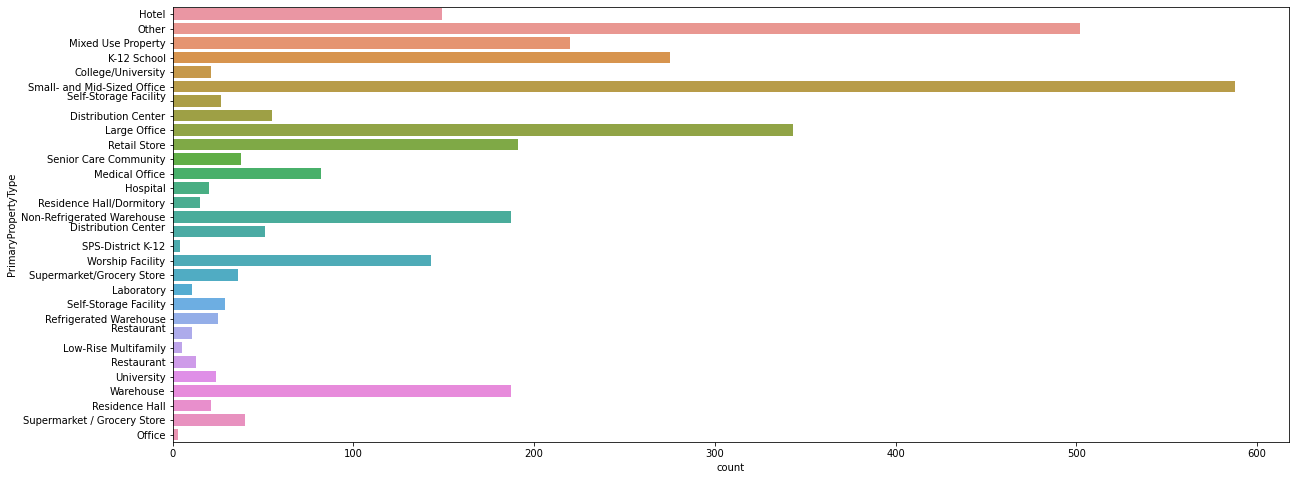

In [49]:
#PrimaryPropertyType
plt.figure(figsize=(20,8))
sns.countplot(y=df['PrimaryPropertyType'], orient='v')

In [50]:
test = df[['PrimaryPropertyType', 'OSEBuildingID']]
dfg=test.groupby(['OSEBuildingID']).agg(set).reset_index()
dfg['taille'] = dfg['PrimaryPropertyType'].apply(lambda x : len(x))
list(dfg[dfg['taille']>1]['PrimaryPropertyType'])

[{'College/University', 'University'},
 {'Self-Storage Facility', 'Self-Storage Facility\n'},
 {'Distribution Center', 'Warehouse'},
 {'Self-Storage Facility', 'Self-Storage Facility\n'},
 {'Other', 'Retail Store'},
 {'College/University', 'University'},
 {'College/University', 'University'},
 {'College/University', 'University'},
 {'Residence Hall', 'Residence Hall/Dormitory'},
 {'Self-Storage Facility', 'Self-Storage Facility\n'},
 {'College/University', 'University'},
 {'Non-Refrigerated Warehouse', 'Warehouse'},
 {'Non-Refrigerated Warehouse', 'Warehouse'},
 {'Self-Storage Facility', 'Self-Storage Facility\n'},
 {'Non-Refrigerated Warehouse', 'Warehouse'},
 {'Distribution Center', 'Distribution Center\n'},
 {'Non-Refrigerated Warehouse', 'Warehouse'},
 {'Non-Refrigerated Warehouse', 'Warehouse'},
 {'K-12 School', 'SPS-District K-12'},
 {'Non-Refrigerated Warehouse', 'Warehouse'},
 {'Residence Hall', 'Residence Hall/Dormitory'},
 {'Mixed Use Property', 'Other'},
 {'Non-Refrigerated 

<AxesSubplot:xlabel='count', ylabel='PrimaryPropertyType'>

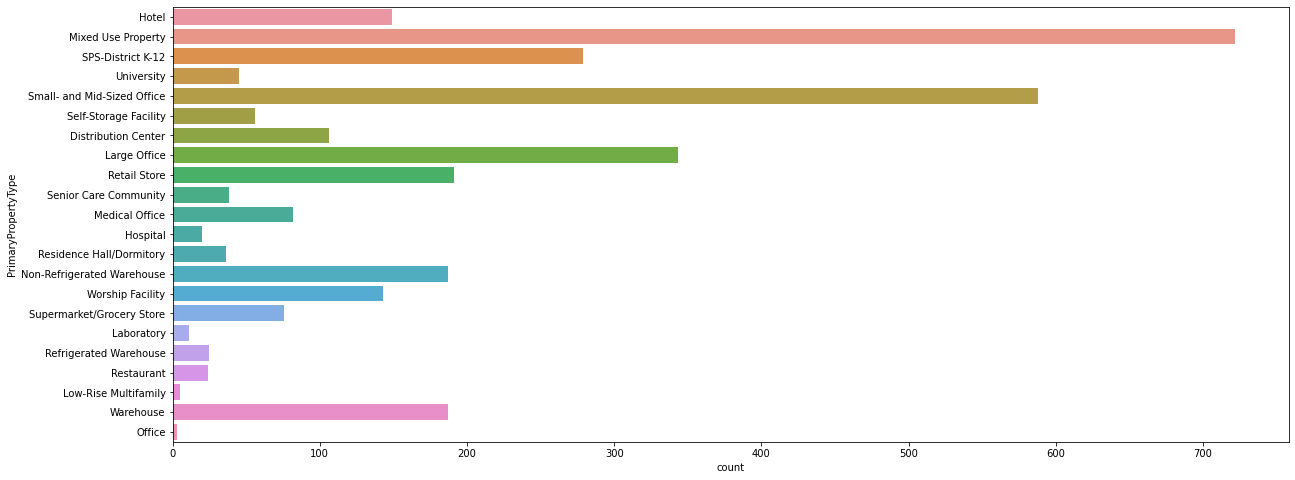

In [51]:
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('College/University', 'University')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Self-Storage Facility\n', 'Self-Storage Facility')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Distribution Center\n', 'Distribution Center')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Residence Hall', 'Residence Hall/Dormitory')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('K-12 School', 'SPS-District K-12')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Supermarket / Grocery Store', \
                                                            'Supermarket/Grocery Store')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Other', \
                                                            'Mixed Use Property')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Restaurant\n', 'Restaurant')
plt.figure(figsize=(20,8))
sns.countplot(y=df['PrimaryPropertyType'], orient='v')

In [52]:
# check des distributions par primary property type
# j'enleve les low rise/mid rise multifamily car données trop nombereuses + outliers qui écrase distribution
def fill_mean(row):
    mean = df_mean[df_mean['PrimaryPropertyType']==row]['SiteEnergyUse(kBtu)'].item()
    return mean
df_test = df.copy()
df_test = df_test[df_test['SiteEnergyUse(kBtu)']<80000000]
df_mean = df_test.groupby(['PrimaryPropertyType'], as_index=False).mean()[['PrimaryPropertyType','SiteEnergyUse(kBtu)']]
df_test['mean_cat'] = df_test['PrimaryPropertyType'].apply(fill_mean)
df_test
df_test=df_test.sort_values(by=['mean_cat'])

<AxesSubplot:ylabel='SiteEnergyUse(kBtu)'>

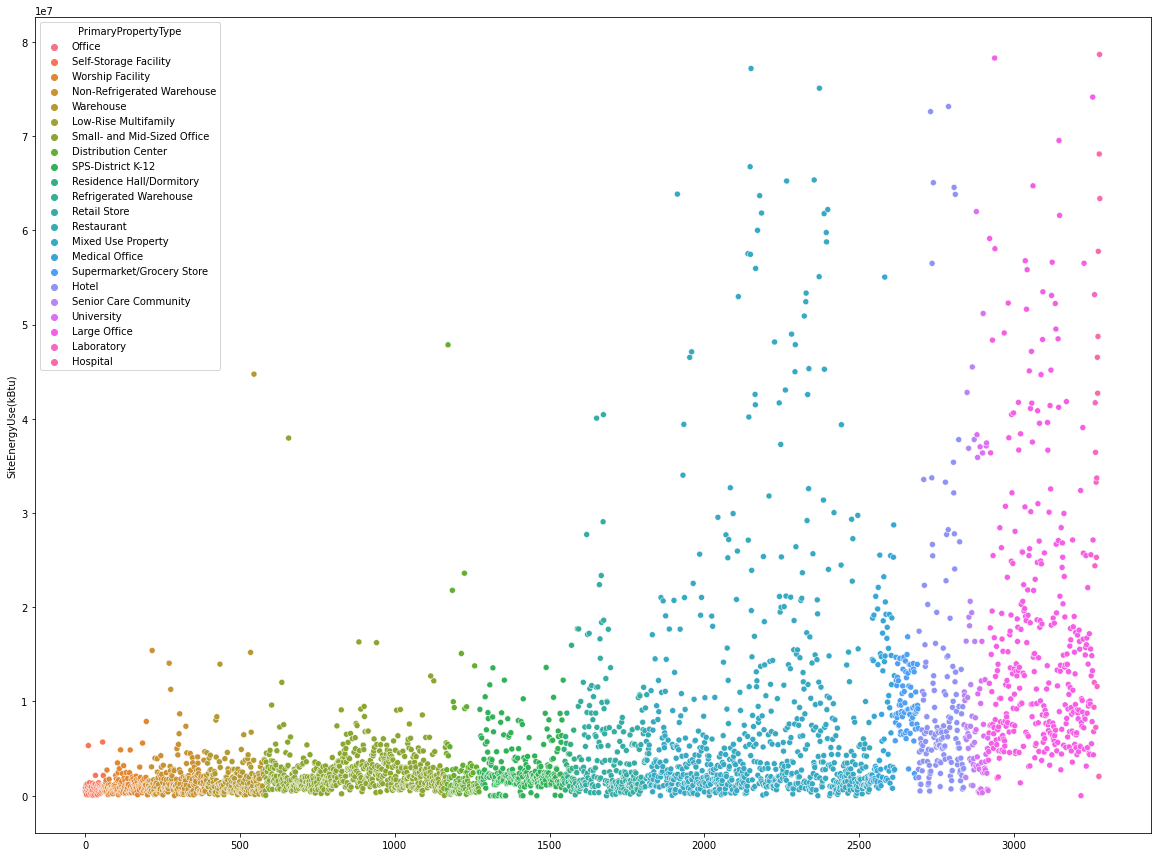

In [53]:
plt.figure(figsize=(20,15))
sns.scatterplot(y=df_test['SiteEnergyUse(kBtu)'], x=[i for i in range(len(df_test))], hue=df_test['PrimaryPropertyType'])


<AxesSubplot:xlabel='SiteEnergyUse(kBtu)', ylabel='PrimaryPropertyType'>

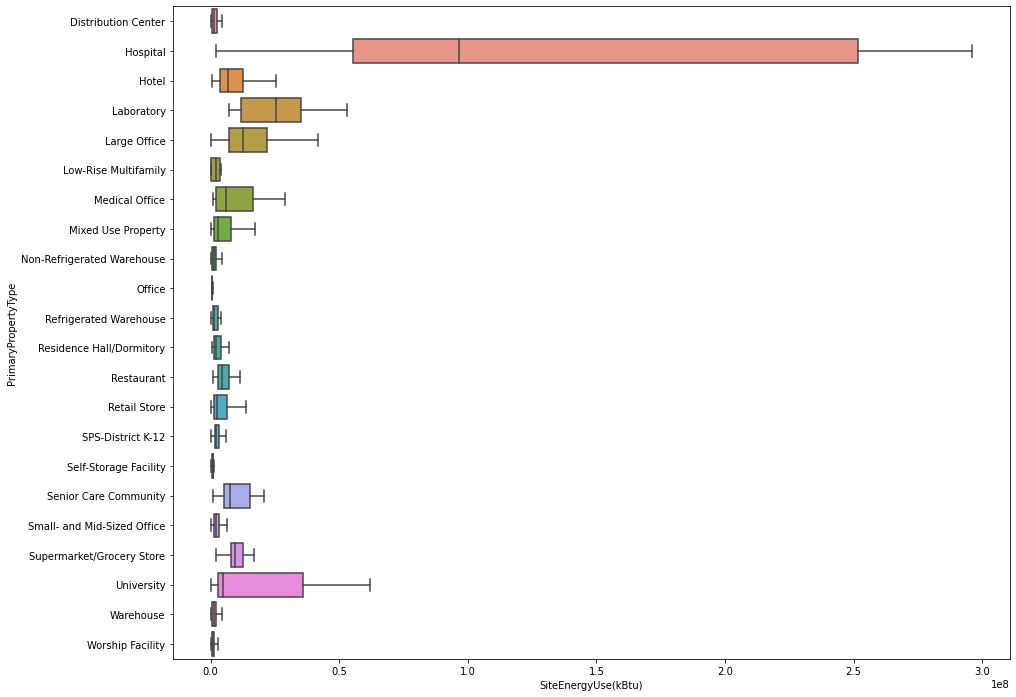

In [54]:
plt.figure(figsize=(15,12))
azerty = df[['SiteEnergyUse(kBtu)', 'PrimaryPropertyType']].sort_values(by='PrimaryPropertyType')
sns.boxplot(y='PrimaryPropertyType', x='SiteEnergyUse(kBtu)', data=azerty, orient='h', showfliers=False)

In [55]:
df_mean.sort_values(by='SiteEnergyUse(kBtu)')

,PrimaryPropertyType,SiteEnergyUse(kBtu)
9,Office,5.800745e+05
15,Self-Storage Facility,9.125161e+05
21,Worship Facility,1.171687e+06
8,Non-Refrigerated Warehouse,1.726504e+06
20,Warehouse,1.961577e+06
5,Low-Rise Multifamily,1.968272e+06
17,Small- and Mid-Sized Office,2.610650e+06
0,Distribution Center,2.801173e+06
14,SPS-District K-12,2.905481e+06
11,Residence Hall/Dormitory,3.138390e+06


<AxesSubplot:xlabel='count', ylabel='PrimaryPropertyType'>

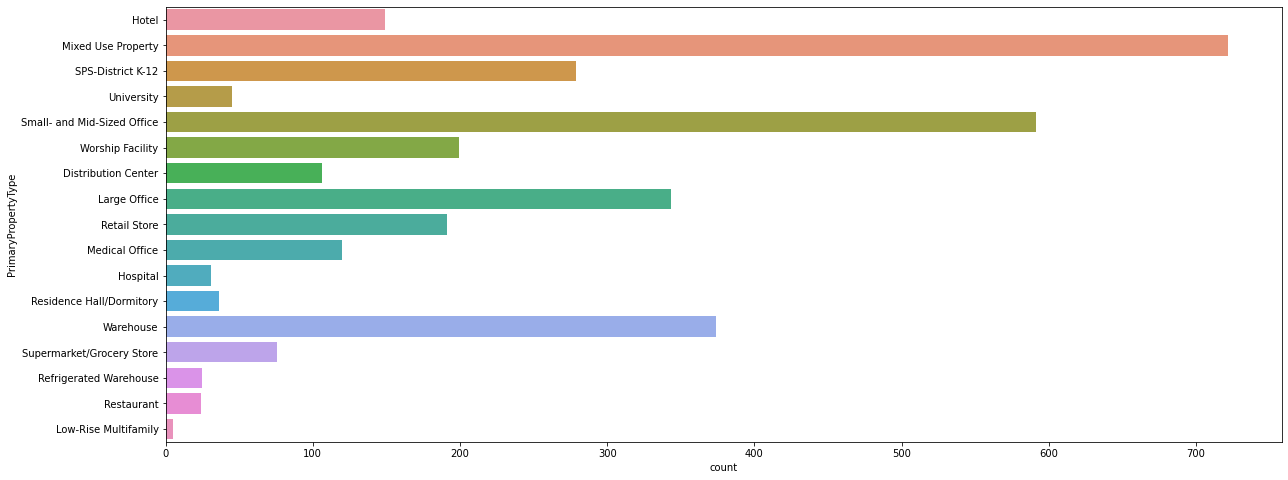

In [56]:
# au vu de ces données :
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Non-Refrigerated Warehouse', 'Warehouse')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Laboratory', 'Hospital')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Self-Storage Facility', 'Worship Facility')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Office', 'Small- and Mid-Sized Office')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Senior Care Community', 'Medical Office')
plt.figure(figsize=(20,8))
sns.countplot(y=df['PrimaryPropertyType'], orient='v')

In [57]:
len(df['PrimaryPropertyType'].unique())

17

In [58]:
df['PrimaryPropertyType'].unique()

array(['Hotel', 'Mixed Use Property', 'SPS-District K-12', 'University',
       'Small- and Mid-Sized Office', 'Worship Facility',
       'Distribution Center', 'Large Office', 'Retail Store',
       'Medical Office', 'Hospital', 'Residence Hall/Dormitory',
       'Warehouse', 'Supermarket/Grocery Store', 'Refrigerated Warehouse',
       'Restaurant', 'Low-Rise Multifamily'], dtype=object)

In [59]:
#Neighborhood
df['Neighborhood']=df['Neighborhood'].str.upper()
df['Neighborhood']=df['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE')
print(df['Neighborhood'].value_counts())

DOWNTOWN                 728
GREATER DUWAMISH         686
MAGNOLIA / QUEEN ANNE    301
LAKE UNION               295
NORTHEAST                243
EAST                     242
NORTHWEST                174
BALLARD                  138
NORTH                    132
CENTRAL                  110
SOUTHEAST                 92
DELRIDGE                  92
SOUTHWEST                 83
Name: Neighborhood, dtype: int64


In [60]:
#ListOfAllPropertyUseTypes
df['PrimaryPropertyType'].unique()

array(['Hotel', 'Mixed Use Property', 'SPS-District K-12', 'University',
       'Small- and Mid-Sized Office', 'Worship Facility',
       'Distribution Center', 'Large Office', 'Retail Store',
       'Medical Office', 'Hospital', 'Residence Hall/Dormitory',
       'Warehouse', 'Supermarket/Grocery Store', 'Refrigerated Warehouse',
       'Restaurant', 'Low-Rise Multifamily'], dtype=object)

In [61]:
df['LargestPropertyUseType'].unique()

array(['Hotel', 'Police Station', 'Other - Entertainment/Public Assembly',
       nan, 'Library', 'Fitness Center/Health Club/Gym',
       'Social/Meeting Hall', 'Courthouse', 'Other', 'K-12 School',
       'College/University', 'Automobile Dealership', 'Office',
       'Self-Storage Facility', 'Retail Store', 'Senior Care Community',
       'Medical Office', 'Hospital (General Medical & Surgical)',
       'Museum', 'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other - Lodging/Residential', 'Residence Hall/Dormitory',
       'Other/Specialty Hospital', 'Financial Office',
       'Non-Refrigerated Warehouse', 'Distribution Center', 'Parking',
       'Multifamily Housing', 'Worship Facility', 'Laboratory',
       'Supermarket/Grocery Store', 'Convention Center',
       'Urgent Care/Clinic/Other Outpatient', 'Other - Services',
       'Strip Mall', 'Wholesale Club/Supercenter',
       'Refrigerated Warehouse', 'Other - Recreation', 'Lifestyle Center',
       'Other - Public S

In [62]:
df_chi2=df.copy(deep=True)
df_chi2=df_chi2[(~df_chi2['SiteEnergyUse(kBtu)'].isna())&(~df_chi2['LargestPropertyUseType'].isna())]
# First, we need to calculate our IQR.
q1 = df_chi2['SiteEnergyUse(kBtu)'].quantile(0.25)                 
q3 = df_chi2['SiteEnergyUse(kBtu)'].quantile(0.75)
iqr = q3 - q1

# Now let's calculate upper and lower bounds.
lower = q1 - 1.5*iqr
upper = q3 + 1.5*iqr

# Let us create our bins:
num_bins = 5
bin_width = (upper - lower) / num_bins
bins = [lower + i*bin_width for i in range(num_bins)]
bins += [upper, float('inf')]  # Now we add our last bin, which will contain any value greater than the upper-bound of the IQR.

# Let us create our labels:
labels = [f'Bucket {i}' for i in range(1,num_bins+1)]
labels.append('Outside IQR')

# Finally, we add a new column to the df:
df_chi2['khi2'] = pd.cut(df_chi2['SiteEnergyUse(kBtu)'], bins=bins, labels=labels)
df_chi2.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,...,Outlier,Latitude,Longitude,City,State,ZipCode,Address,parking_ratio,building_ratio,khi2
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1.0,...,NaN,47.61219025,-122.33799744,SEATTLE,WA,98101,NaN,0.000000,100.000000,Bucket 4
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,7,DOWNTOWN,1996,1.0,...,NaN,47.61310583,-122.33335756,SEATTLE,WA,98101,NaN,14.545314,85.454686,Bucket 4
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,7,DOWNTOWN,1969,1.0,...,NaN,47.61334897,-122.33769944,SEATTLE,WA,98101,NaN,0.000000,100.000000,Outside IQR
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,7,DOWNTOWN,1926,1.0,...,High Outlier,47.61421585,-122.33660889,SEATTLE,WA,98101,NaN,0.000000,100.000000,Outside IQR
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,7,DOWNTOWN,1980,1.0,...,NaN,47.6137544,-122.3409238,SEATTLE,WA,98121,NaN,10.392860,89.607140,Bucket 5


In [63]:
cross_table = pd.crosstab(index=df_chi2['khi2'],columns=df_chi2['LargestPropertyUseType'])
cross_table

LargestPropertyUseType,Adult Education,Automobile Dealership,Bank Branch,College/University,Convention Center,Courthouse,Data Center,Distribution Center,Financial Office,Fire Station,...,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Strip Mall,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Wholesale Club/Supercenter,Worship Facility
khi2,,,,,,,,,,,,,,,,,,,,,
Bucket 2,2,4,8,8,1,0,0,69,2,0,...,1,80,52,2,9,2,2,0,0,117
Bucket 3,2,7,0,15,0,0,0,29,4,2,...,11,67,2,13,9,4,8,4,0,23
Bucket 4,0,0,0,4,0,0,0,4,1,0,...,8,30,0,11,2,1,39,0,0,1
Bucket 5,0,0,0,4,0,0,0,2,0,0,...,2,9,0,2,0,3,28,0,2,0
Outside IQR,0,0,0,13,1,2,5,2,0,0,...,1,12,0,10,0,2,1,4,0,0


In [64]:
def cramers_v(cross_tabs):
    """
    Prints the degrees of freedom, effect size thresholds, and Cramer's V value.

    Args:
        cross_tabs: A crosstab dataframe.
    """


    # effect size data frame for cramer's v function
    data = np.array([[1, .1, .3, .5],
       [2, .07, .21, .35],
       [3, .06, .17, .29],
       [4, .05,.15,.25],
       [5, .04, .13, .22]])
    sizes = pd.DataFrame(data, columns=['Degrees of Freedom', 'Small Effect', 'Medium Effect', 'Large Effect'])

    # getting the chi sq. stat
    chi2 = stats.chi2_contingency(cross_tabs)[0]
    # calculating the total number of observations
    n = cross_tabs.sum().sum()
    # getting the degrees of freedom
    dof = min(cross_tabs.shape)-1
    # calculating cramer's v
    v = np.sqrt(chi2/(n*dof))
    # printing results
    print(f'V = {v}')
    print(f'Cramer\'s V Degrees of Freedom = {dof}')
    print(f'\nEffect Size Thresholds\n{sizes}\n')

cramers_v(cross_table)

V = 0.35013201957931966
Cramer's V Degrees of Freedom = 4

Effect Size Thresholds
   Degrees of Freedom  Small Effect  Medium Effect  Large Effect
0                 1.0          0.10           0.30          0.50
1                 2.0          0.07           0.21          0.35
2                 3.0          0.06           0.17          0.29
3                 4.0          0.05           0.15          0.25
4                 5.0          0.04           0.13          0.22



In [65]:
# la colonne LargestPropertyUseType semble intéréssante au vu du khi2, mais beaucoup de travail

In [66]:
from scipy.stats import chi2_contingency as chi2_contingency
khi2, pval , ddl , contingent_theorique = chi2_contingency(cross_table)
print(f'khi2 : {khi2}, pval : {pval}, degré de liberté : {ddl}')

khi2 : 1587.817168056545, pval : 8.007046769174071e-204, degré de liberté : 224


In [67]:
#latitude-longitude
df['Latitude'] = df['Latitude'].astype('float')
df['Longitude'] = df['Longitude'].astype('float')

In [68]:
to_drop=[
    'TaxParcelIdentificationNumber', #pas d'interet
    'PropertyName', # pas d'interet
    'ListOfAllPropertyUseTypes', # pas d'interet
    'LargestPropertyUseType',# a voir mais beaucoup de taf
    'SecondLargestPropertyUseType',# a voir mais beaucoup de taf
    'ThirdLargestPropertyUseType',# a voir mais beaucoup de taf + nan +++
    "YearsENERGYSTARCertified", #trop de nan + pas d'interet
    'DefaultData',
    'ComplianceStatus',
    'City',
    'State',
    'Address',
    'ZipCode',
    'Comments',
    'Outlier'
]

In [69]:
print(df['SiteEnergyUse(kBtu)'].mean())
print(df[df['Outlier'].isin(['High Outlier', 'High outlier'])]['SiteEnergyUse(kBtu)'].mean())
print(df['TotalGHGEmissions'].mean())
print(df[df['Outlier'].isin(['High Outlier', 'High outlier'])]['TotalGHGEmissions'].mean())

8068387.644949252
20523515.4375
176.99036589053475
343.655625


In [70]:
df=df[~df['Outlier'].isin(['High Outlier', 'High outlier'])]

In [71]:
df[~df['Comments'].isna()]['Comments']

62      Under construction starting 6/2013 (old buildi...
436     Part of McKinstry's campus, property operates ...
437     One of two office buildings on McKinstry's cam...
595     Part of McKinstry’s campus, this remodeled war...
719     Construction completed in mid 2015. The buildi...
1358    Under construction starting 6/2013 (old buildi...
1360    Under construction starting 6/2013 (old buildi...
1373    Under construction starting 6/2015 (old buildi...
2108    Under construction starting 09/2014 (old build...
2230    Part of McKinstry's campus, the office space f...
2319    Part of McKinstry's campus, property includes ...
2381    Property now has two buildings: Thornton Creek...
Name: Comments, dtype: object

In [72]:
df=df.drop(columns=to_drop)

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3300 entries, 0 to 3375
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   OSEBuildingID           3300 non-null   int64  
 1   DataYear                3300 non-null   int64  
 2   BuildingType            3300 non-null   object 
 3   PrimaryPropertyType     3300 non-null   object 
 4   CouncilDistrictCode     3300 non-null   int64  
 5   Neighborhood            3300 non-null   object 
 6   YearBuilt               3300 non-null   int64  
 7   NumberofBuildings       3300 non-null   float64
 8   NumberofFloors          3300 non-null   float64
 9   PropertyGFABuilding(s)  3300 non-null   int64  
 10  ENERGYSTARScore         2197 non-null   float64
 11  SiteEnergyUse(kBtu)     3291 non-null   float64
 12  TotalGHGEmissions       3291 non-null   float64
 13  Latitude                3300 non-null   float64
 14  Longitude               3300 non-null   

In [74]:
df['BuildingAge']=df['DataYear']-df['YearBuilt']
df.drop(columns=['YearBuilt'],inplace=True)

# Deal with duplicate building

In [75]:
df = df[(df['SiteEnergyUse(kBtu)']>0)&df['TotalGHGEmissions']>0]

In [76]:
df.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'CouncilDistrictCode', 'Neighborhood', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFABuilding(s)', 'ENERGYSTARScore',
       'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'Latitude', 'Longitude',
       'parking_ratio', 'building_ratio', 'BuildingAge'],
      dtype='object')

In [113]:
az = df.copy()
aze = az.groupby('OSEBuildingID', as_index=False).agg(list)
aze['len_building_type']=aze.PrimaryPropertyType.apply(lambda x : len(list(set(x))))
aze['len_building_type'].value_counts()

1    1659
2      34
Name: len_building_type, dtype: int64

In [78]:
df = df.groupby('OSEBuildingID', as_index=False).agg({'BuildingType': max, 
                                               'PrimaryPropertyType': max,
                                               'CouncilDistrictCode': max,
                                               'Neighborhood': max,
                                               'NumberofBuildings': np.mean,
                                                'NumberofFloors': np.mean,
                                                'PropertyGFABuilding(s)': np.mean,
                                                'ENERGYSTARScore': np.mean,
                                                'SiteEnergyUse(kBtu)': np.mean,
                                                'TotalGHGEmissions':np.mean,
                                                'Latitude': max,
                                                'Longitude':max,
                                                'parking_ratio': np.mean,
                                                'building_ratio': np.mean,
                                                'BuildingAge': max}

                                               )

In [79]:
df.describe()

,OSEBuildingID,CouncilDistrictCode,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,Latitude,Longitude,parking_ratio,building_ratio,BuildingAge
count,1693.000000,1693.000000,1693.000000,1693.000000,1.693000e+03,1151.000000,1.693000e+03,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000
mean,16372.528647,4.366214,1.164501,4.115180,1.050674e+05,65.111642,8.462877e+06,185.582812,47.616266,-122.332711,6.089480,93.910521,54.301831
std,13808.429633,2.190263,2.812075,6.519771,2.810708e+05,27.893632,3.016059e+07,746.944449,0.048020,0.024559,13.433711,13.433712,32.861382
min,1.000000,1.000000,1.000000,1.000000,1.092500e+04,1.000000,1.697945e+04,0.120000,47.499331,-122.411662,0.000000,20.183257,1.000000
25%,585.000000,2.000000,1.000000,1.000000,2.836800e+04,47.250000,1.239379e+06,20.255000,47.586003,-122.342870,0.000000,100.000000,27.000000
50%,21177.000000,4.000000,1.000000,2.000000,4.736800e+04,72.500000,2.547582e+06,50.215000,47.612497,-122.332773,0.000000,100.000000,51.000000
75%,24603.000000,7.000000,1.000000,4.000000,9.494800e+04,88.250000,6.893473e+06,139.530000,47.649473,-122.321480,0.000000,100.000000,86.000000
max,50226.000000,7.000000,111.000000,99.000000,9.320156e+06,100.000000,8.739237e+08,16870.980000,47.733870,-122.258640,79.816743,100.001461,116.000000


In [80]:
df

,OSEBuildingID,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,Latitude,Longitude,parking_ratio,building_ratio,BuildingAge
0,1,NonResidential,Hotel,7,DOWNTOWN,1.0,12.0,88434.0,62.5,7.103895e+06,249.705,47.612200,-122.337990,0.000000,100.000000,89
1,2,NonResidential,Hotel,7,DOWNTOWN,1.0,11.0,88502.0,56.0,8.371084e+06,279.685,47.613170,-122.333358,14.545314,85.454686,20
2,3,NonResidential,Hotel,7,DOWNTOWN,1.0,41.0,860691.0,30.5,7.285884e+07,2075.380,47.613930,-122.337699,10.287415,89.712585,47
3,5,NonResidential,Hotel,7,DOWNTOWN,1.0,10.0,61320.0,56.0,6.794584e+06,286.430,47.614120,-122.336640,0.000000,100.000000,90
4,8,NonResidential,Hotel,7,DOWNTOWN,1.0,18.0,110505.0,71.0,1.450085e+07,506.355,47.613754,-122.340470,22.852200,77.147800,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1688,50222,NonResidential,Small- and Mid-Sized Office,2,GREATER DUWAMISH,1.0,1.0,12294.0,46.0,8.497457e+05,20.940,47.567220,-122.311540,0.000000,100.000000,26
1689,50223,NonResidential,Mixed Use Property,2,DOWNTOWN,1.0,1.0,16000.0,NaN,9.502762e+05,32.170,47.596250,-122.322830,0.000000,100.000000,12
1690,50224,NonResidential,Mixed Use Property,7,MAGNOLIA / QUEEN ANNE,1.0,1.0,13157.0,NaN,5.765898e+06,223.540,47.636440,-122.357840,0.000000,100.000000,42
1691,50225,NonResidential,Mixed Use Property,1,GREATER DUWAMISH,1.0,1.0,14101.0,NaN,7.194712e+05,22.110,47.528320,-122.324310,0.000000,100.000000,27


In [81]:
#df['SiteEnergyUse(kBtu)']
print(df['BuildingType'].value_counts())
df[df['SiteEnergyUse(kBtu)']>df['SiteEnergyUse(kBtu)'].quantile(0.75)]['BuildingType'].value_counts()

NonResidential       1572
SPS-District K-12      97
Campus                 24
Name: BuildingType, dtype: int64


NonResidential       395
Campus                16
SPS-District K-12     12
Name: BuildingType, dtype: int64

In [82]:
# j'enleve les campus
df=df[~df['BuildingType'].str.contains('Campus')]

## Nan values energystarscore

In [83]:
print(len(df[~df['ENERGYSTARScore'].isna()]))
df['ENERGYSTARScore'] = df['ENERGYSTARScore'].fillna(df.groupby('OSEBuildingID')['ENERGYSTARScore'].transform('max'))
len(df[~df['ENERGYSTARScore'].isna()])

1146


/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


1146

<AxesSubplot:xlabel='ENERGYSTARScore', ylabel='PrimaryPropertyType'>

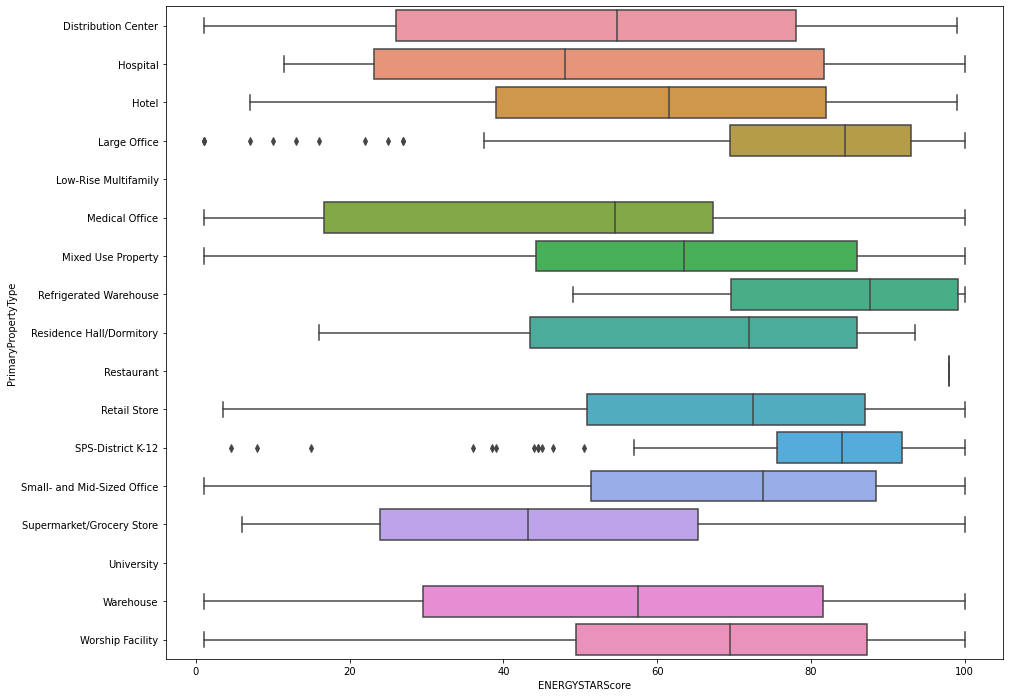

In [84]:
plt.figure(figsize=(15,12))
azerty = df[['ENERGYSTARScore', 'PrimaryPropertyType']].sort_values(by='PrimaryPropertyType')
sns.boxplot(y='PrimaryPropertyType', x='ENERGYSTARScore', data=azerty, orient='h')

<AxesSubplot:>

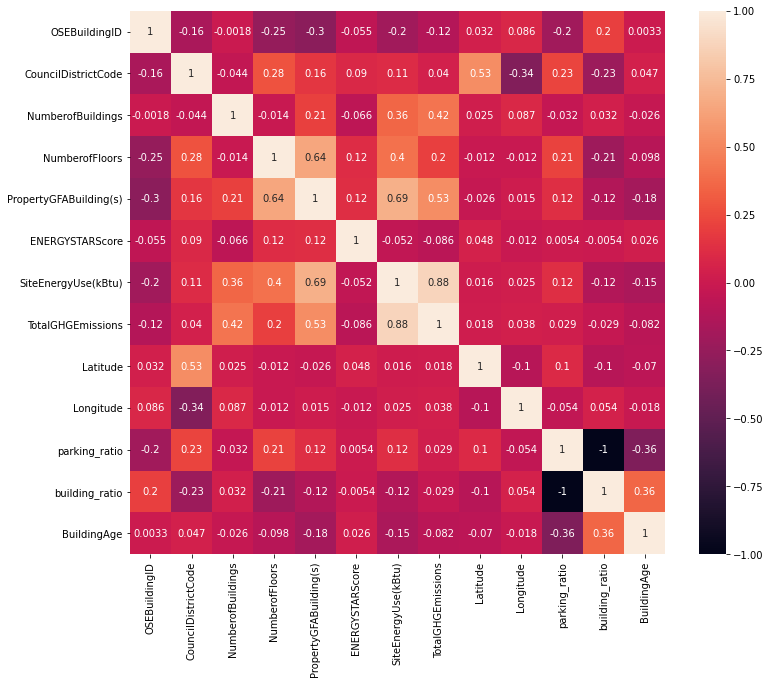

In [85]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True)

In [86]:
locationlist=[]
for index, row in df.iterrows():
    lat = row['Latitude']
    long=row['Longitude']
    locationlist.append([lat, long])

In [87]:
map = folium.Map(location=[df['Latitude'].median(), df['Longitude'].median()], zoom_start=12)
for point in range(0, len(df)):
    folium.CircleMarker(locationlist[point],radius=5).add_to(map)
map

In [88]:
a = df[['CouncilDistrictCode', 'Neighborhood']].groupby('CouncilDistrictCode')['Neighborhood'].apply(list)

In [89]:
def count_(list_code):
    dict_count={}
    items = set(list_code)
    for item in items :
        dict_count[item]=list_code.count(item)
    return dict_count
for i in range (1,8):
    print(count_(a[i]))

{'GREATER DUWAMISH': 29, 'DELRIDGE': 45, 'SOUTHWEST': 41}
{'GREATER DUWAMISH': 310, 'EAST': 1, 'SOUTHEAST': 44, 'DOWNTOWN': 44}
{'SOUTHEAST': 4, 'LAKE UNION': 14, 'NORTHEAST': 1, 'GREATER DUWAMISH': 5, 'EAST': 114, 'CENTRAL': 54, 'DOWNTOWN': 11}
{'NORTHEAST': 121, 'LAKE UNION': 48, 'NORTH': 2}
{'NORTHEAST': 4, 'NORTHWEST': 64, 'NORTH': 65}
{'BALLARD': 72, 'LAKE UNION': 22, 'NORTHWEST': 23}
{'EAST': 7, 'LAKE UNION': 66, 'DOWNTOWN': 308, 'MAGNOLIA / QUEEN ANNE': 150}


In [90]:
locationlist_2=[]
locationlist=[]
df_1=df[df['CouncilDistrictCode']==2]
df_2=df[df['CouncilDistrictCode']==3]
locationlist=[]
for index, row in df_1.iterrows():
    lat = row['Latitude']
    long=row['Longitude']
    locationlist.append([lat, long])
for index, row in df_2.iterrows():
    lat = row['Latitude']
    long=row['Longitude']
    locationlist_2.append([lat, long])
map = folium.Map(location=[df_1['Latitude'].median(), df_1['Longitude'].median()], zoom_start=12)
for point in range(0, len(df_1)):
    folium.CircleMarker(locationlist[point],radius=5, color='red').add_to(map)
for point in range(0, len(df_2)):
    folium.CircleMarker(locationlist_2[point],radius=5, color='blue').add_to(map)
map

In [91]:
# il semblerait que la variable CouncilDistrictCode ne soit pas pertinente -> on preferera encoder les quartiers

In [92]:
df.drop(columns=['CouncilDistrictCode'], inplace=True)

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [93]:
df['BuildingType'].unique()

array(['NonResidential', 'SPS-District K-12'], dtype=object)

In [94]:
numeric_columns= list(df.select_dtypes('float').columns) +list(df.select_dtypes('int').columns)
numeric_columns

['NumberofBuildings',
 'NumberofFloors',
 'PropertyGFABuilding(s)',
 'ENERGYSTARScore',
 'SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'Latitude',
 'Longitude',
 'parking_ratio',
 'building_ratio',
 'OSEBuildingID',
 'BuildingAge']

In [95]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder


for column in list(df.select_dtypes('O').columns):
    encoder=OneHotEncoder(sparse=False)
    cat_encoded = pd.DataFrame(encoder.fit_transform(df[[column]]))

    cat_encoded.columns = encoder.get_feature_names([column])
    df.reset_index(inplace=True, drop=True)
    df= pd.concat([df, cat_encoded], axis=1)
    df.drop(columns=[column], inplace=True)

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [96]:
df.columns

Index(['OSEBuildingID', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFABuilding(s)', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)',
       'TotalGHGEmissions', 'Latitude', 'Longitude', 'parking_ratio',
       'building_ratio', 'BuildingAge', 'BuildingType_NonResidential',
       'BuildingType_SPS-District K-12',
       'PrimaryPropertyType_Distribution Center',
       'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Low-Rise Multifamily',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property',
       'PrimaryPropertyType_Refrigerated Warehouse',
       'PrimaryPropertyType_Residence Hall/Dormitory',
       'PrimaryPropertyType_Restaurant', 'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_SPS-District K-12',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket/Grocery Store',
       'PrimaryPropertyType

<AxesSubplot:>

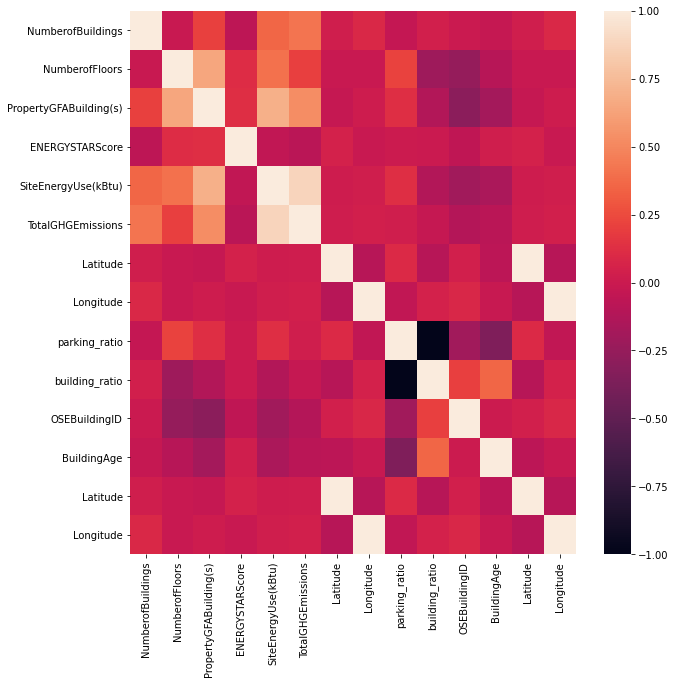

In [97]:
numeric_columns.append('Latitude')
numeric_columns.append('Longitude')
plt.figure(figsize=(10,10))
sns.heatmap(df[numeric_columns].corr())

<AxesSubplot:>

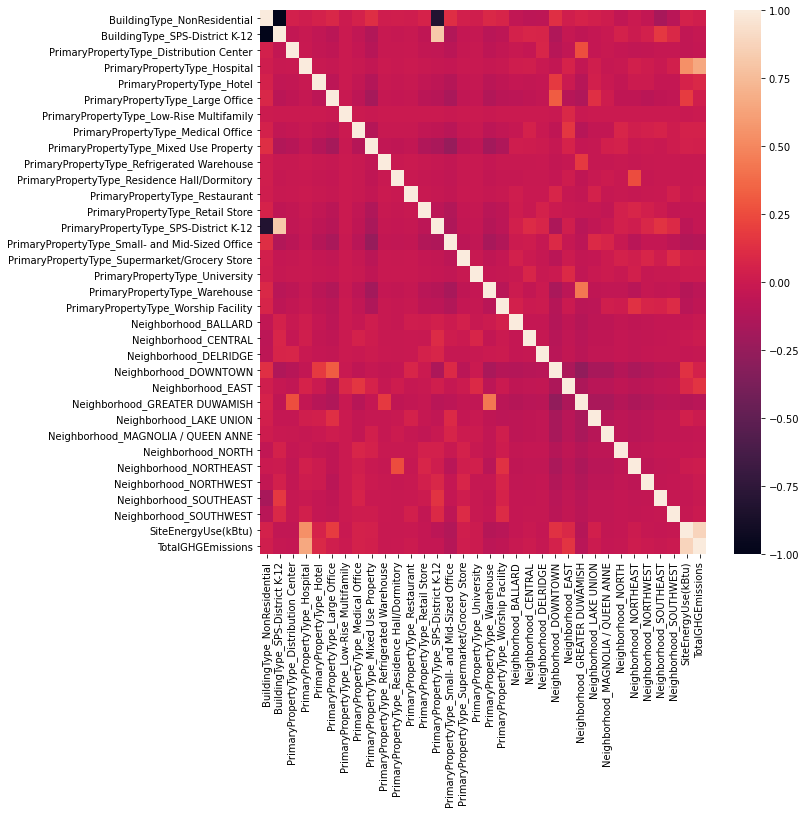

In [98]:
cat_col = [i for i in list(df.columns) if i not in numeric_columns]
cat_col.append('SiteEnergyUse(kBtu)')
cat_col.append('TotalGHGEmissions')
plt.figure(figsize=(10,10))
sns.heatmap(df[cat_col].corr())

# Normaliser les colonnes

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


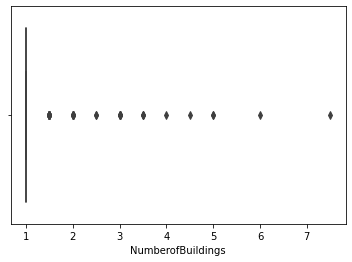

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


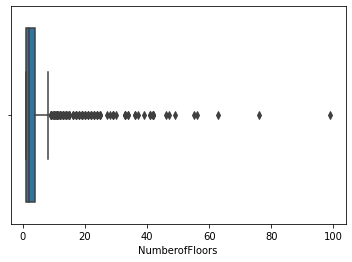

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


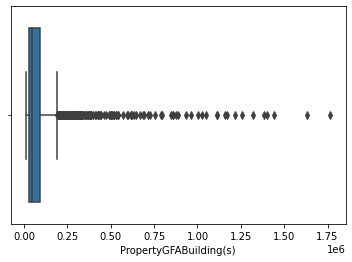

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


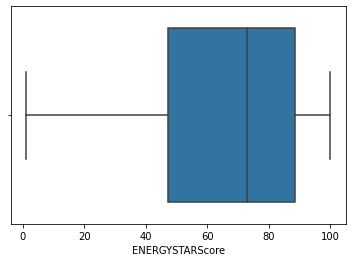

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


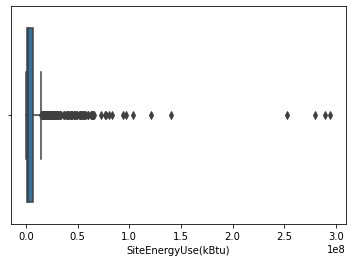

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


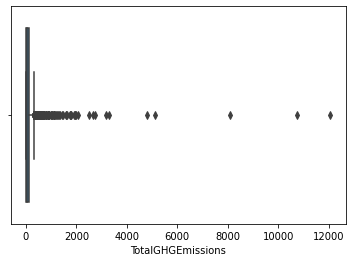

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


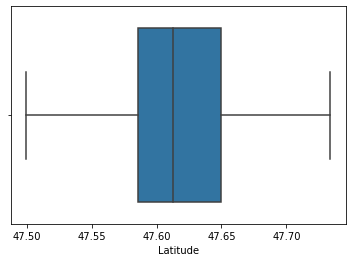

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


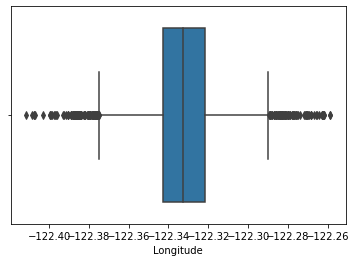

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


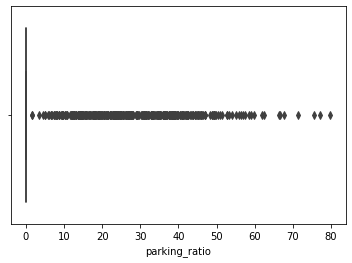

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


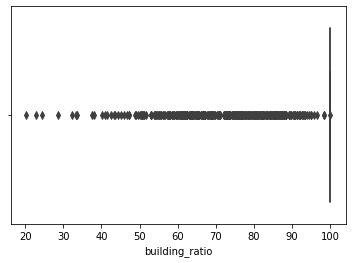

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


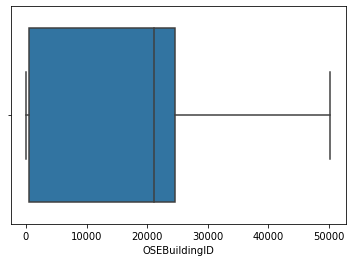

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


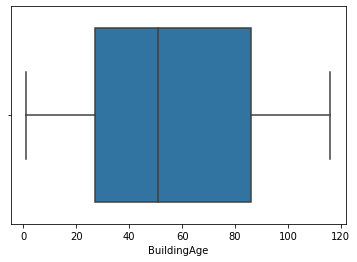

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


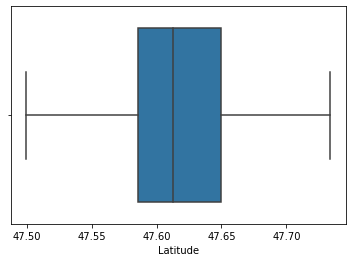

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


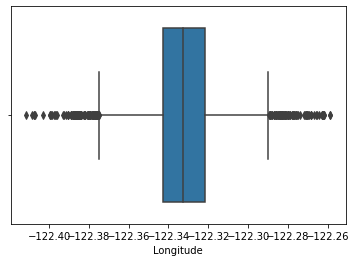

In [99]:
for column in numeric_columns :
    sns.boxplot(df[column])
    plt.show()

In [100]:
#je vais voir si j'enleve les données ou site energie use et total emission sont très élévées, j'obtiens de meilleures graphiques
'''q = df_['SiteEnergyUse(kBtu)'].quantile(0.99)
q
df_ = df_[df_['SiteEnergyUse(kBtu)']<q]'''

"q = df_['SiteEnergyUse(kBtu)'].quantile(0.99)\nq\ndf_ = df_[df_['SiteEnergyUse(kBtu)']<q]"

On peut voir pas mal d'outliers -> Robustscaler \
Pour les targets -> on veut normaliser la distrbution : boxcox ou log

In [101]:
to_robust = [
    'NumberofBuildings',
    'NumberofFloors',
    'ENERGYSTARScore',
    'PropertyGFABuilding(s)',
    'BuildingAge',
    'parking_ratio',
    'building_ratio'
            ]
to_drop = ['Latitude',
             'Longitude',
          'OSEBuildingID',
          'DataYear']
targets=['SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',]

In [102]:

for column in to_robust:
    transformer = RobustScaler(unit_variance=True).fit(df[[column]])
    df[column] = transformer.transform(df[[column]])

In [103]:
df['NumberofBuildings'].value_counts()

0.000000    1628
0.674490      15
1.348980       8
2.697959       7
3.372449       3
5.395918       2
2.023469       2
4.046939       1
4.721428       1
6.744898       1
8.768367       1
Name: NumberofBuildings, dtype: int64

In [104]:
df.columns

Index(['OSEBuildingID', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFABuilding(s)', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)',
       'TotalGHGEmissions', 'Latitude', 'Longitude', 'parking_ratio',
       'building_ratio', 'BuildingAge', 'BuildingType_NonResidential',
       'BuildingType_SPS-District K-12',
       'PrimaryPropertyType_Distribution Center',
       'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Low-Rise Multifamily',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property',
       'PrimaryPropertyType_Refrigerated Warehouse',
       'PrimaryPropertyType_Residence Hall/Dormitory',
       'PrimaryPropertyType_Restaurant', 'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_SPS-District K-12',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket/Grocery Store',
       'PrimaryPropertyType

In [105]:
df.to_csv('./dataframe_clean_groupby.csv')